# Task-3: Variational Autoencoder (VAE)

by Dechathon Niamsa-ard [st126235]

Implement a VAE to learn latent representations of images, generate new samples, and analyze the effect of latent dimensionality

**Instructions:**

**Dataset:** Use MNIST, and preprocess

**Model Implementation**:
- Encoder: 3–4 Conv layers → flatten → Linear → output μ and log(σ²)
- Use latent dimension of 128
- Decoder: transpose convolutions → reconstruct image.
- 
**Training**
- Loss: Reconstruction (MSE or BCE), KL divergence term
- Optimizer: Adam
- Train for 50 epochs.

- Visualize reconstruction and latent space evolution.
- Generation and Visualization: Sample random z vectors → generate images.
- Interpolate between two z vectors to observe smooth transitions.
- Change latent dimension to 256, retrain the model, and visualize generated images and reconstruction quality.

**Deliverable:**

- Jupyter notebook with clear code and comments.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for saving models
os.makedirs('models/task_3', exist_ok=True)

Using device: cuda


100%|██████████| 9.91M/9.91M [00:03<00:00, 3.02MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 111kB/s]

100%|██████████| 1.65M/1.65M [00:01<00:00, 906kB/s] 

100%|██████████| 4.54k/4.54k [00:00<00:00, 6.50MB/s]



Training samples: 60000
Test samples: 10000


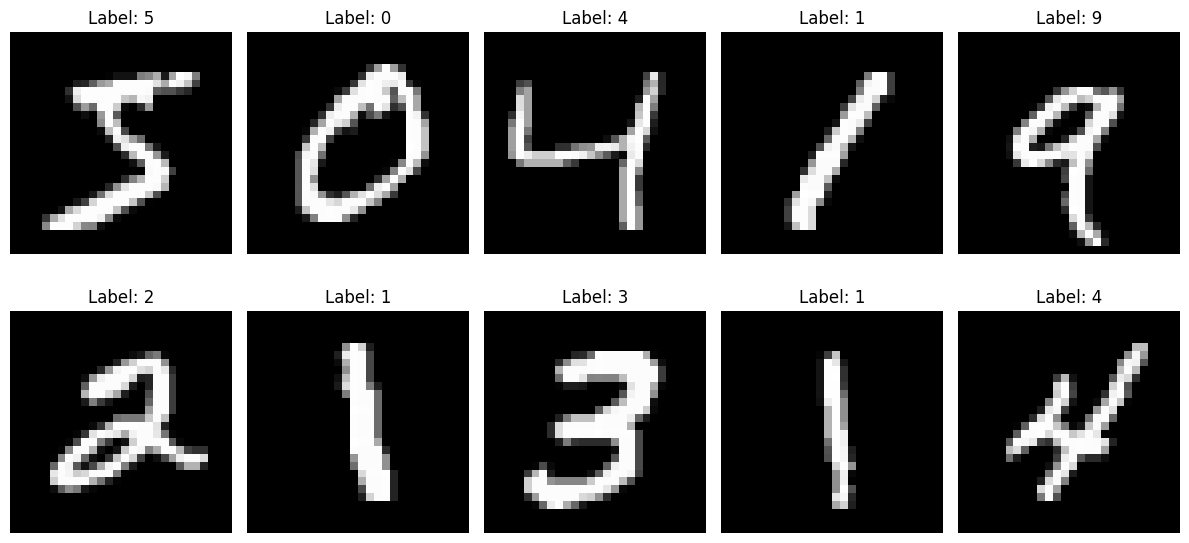

In [2]:
# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    image, label = train_dataset[i]
    axes[i//5, i%5].imshow(image.squeeze(), cmap='gray')
    axes[i//5, i%5].set_title(f'Label: {label}')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

In [10]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            # First conv layer: 1 -> 32
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            # Second conv layer: 32 -> 64
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            # Third conv layer: 64 -> 128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7 -> 3x3
            nn.ReLU(),
            # Fourth conv layer: 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 3x3 -> 3x3
            nn.ReLU(),
        )
        
        # Calculate the flattened size after convolutions
        self.flatten_size = 256 * 3 * 3  # 2304
        
        # Linear layers for mean and log variance
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder - start with a larger feature map for better reconstruction
        self.fc_decode = nn.Linear(latent_dim, 256 * 7 * 7)  # Start with 7x7 feature maps
        
        self.decoder = nn.Sequential(
            # First transpose conv: 256 -> 128  (7x7 -> 14x14)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Second transpose conv: 128 -> 64  (14x14 -> 28x28)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Third conv layer for refinement: 64 -> 32
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            # Final conv layer: 32 -> 1
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.Tanh()  # Output in [-1, 1] to match input normalization
        )
    
    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent vector to image"""
        h = self.fc_decode(z)
        h = h.view(h.size(0), 256, 7, 7)  # Reshape to 7x7 feature maps
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Test the model architecture
model = VAE(latent_dim=128).to(device)
print("VAE model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Let's test the forward pass to ensure dimensions are correct
with torch.no_grad():
    test_input = torch.randn(1, 1, 28, 28).to(device)
    test_output, test_mu, test_logvar = model(test_input)
    print(f"\nDimension check:")
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"Latent mu shape: {test_mu.shape}")
    print(f"Latent logvar shape: {test_logvar.shape}")
    if test_output.shape[-2:] == (28, 28):
        print("✓ All dimensions are correct!")
    else:
        print(f"⚠ Output size is {test_output.shape[-2:]} instead of (28, 28)")

VAE model architecture:
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=2304, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=2304, out_features=128, bias=True)
  (fc_decode): Linear(in_features=128, out_features=12544, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1,

In [4]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss function combining reconstruction loss and KL divergence
    
    Args:
        recon_x: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: Weight for KL divergence term
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence loss
    # KL(q(z|x) || p(z)) where p(z) = N(0, I)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

def train_vae(model, train_loader, optimizer, epoch, beta=1.0):
    """Train VAE for one epoch"""
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (data, _) in enumerate(progress_bar):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Calculate loss
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item()/len(data):.4f}',
            'Recon': f'{recon_loss.item()/len(data):.4f}',
            'KL': f'{kl_loss.item()/len(data):.4f}'
        })
    
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = train_recon_loss / len(train_loader.dataset)
    avg_kl_loss = train_kl_loss / len(train_loader.dataset)
    
    return avg_loss, avg_recon_loss, avg_kl_loss

def test_vae(model, test_loader, beta=1.0):
    """Evaluate VAE on test set"""
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_kl_loss += kl_loss.item()
    
    avg_loss = test_loss / len(test_loader.dataset)
    avg_recon_loss = test_recon_loss / len(test_loader.dataset)
    avg_kl_loss = test_kl_loss / len(test_loader.dataset)
    
    return avg_loss, avg_recon_loss, avg_kl_loss

In [11]:
# Training the VAE with latent dimension 128
latent_dim_128 = 128
model_128 = VAE(latent_dim=latent_dim_128).to(device)
optimizer_128 = optim.Adam(model_128.parameters(), lr=1e-3)

# Training parameters
num_epochs = 50
beta = 1.0  # Weight for KL divergence

# Storage for training history
train_losses_128 = []
train_recon_losses_128 = []
train_kl_losses_128 = []
test_losses_128 = []

print("Training VAE with latent dimension 128...")
print("=" * 50)

for epoch in range(1, num_epochs + 1):
    # Train
    train_loss, train_recon_loss, train_kl_loss = train_vae(
        model_128, train_loader, optimizer_128, epoch, beta
    )
    
    # Test
    test_loss, test_recon_loss, test_kl_loss = test_vae(model_128, test_loader, beta)
    
    # Store losses
    train_losses_128.append(train_loss)
    train_recon_losses_128.append(train_recon_loss)
    train_kl_losses_128.append(train_kl_loss)
    test_losses_128.append(test_loss)
    
    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:02d}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'          Train Recon: {train_recon_loss:.4f}, Train KL: {train_kl_loss:.4f}')

print("Training completed!")
print("=" * 50)

# Save the trained model
torch.save(model_128.state_dict(), 'models/task_3/vae_128_final.pth')
print("Model saved to models/task_3/vae_128_final.pth")

Training VAE with latent dimension 128...


Epoch 1: 100%|██████████| 469/469 [00:07<00:00, 58.75it/s, Loss=91.9567, Recon=63.1203, KL=28.8363]  

Epoch 3: 100%|██████████| 469/469 [00:07<00:00, 61.99it/s, Loss=63.4978, Recon=36.1643, KL=27.3335]

Epoch 5: 100%|██████████| 469/469 [00:07<00:00, 60.55it/s, Loss=62.6247, Recon=32.6065, KL=30.0182]

Epoch 6: 100%|██████████| 469/469 [00:07<00:00, 60.22it/s, Loss=60.5090, Recon=32.7809, KL=27.7281]

Epoch 7: 100%|██████████| 469/469 [00:07<00:00, 59.62it/s, Loss=57.3015, Recon=29.5721, KL=27.7295]

Epoch 8: 100%|██████████| 469/469 [00:08<00:00, 57.90it/s, Loss=57.6378, Recon=29.6524, KL=27.9853]

Epoch 9: 100%|██████████| 469/469 [00:08<00:00, 58.05it/s, Loss=57.8160, Recon=30.4642, KL=27.3518]

Epoch 10: 100%|██████████| 469/469 [00:08<00:00, 57.15it/s, Loss=55.5293, Recon=28.9780, KL=26.5513]



Epoch 10: Train Loss: 57.5253, Test Loss: 57.3057
          Train Recon: 29.8921, Train KL: 27.6332


Epoch 11: 100%|██████████| 469/469 [00:08<00:00, 58.23it/s, Loss=55.6076, Recon=28.4584, KL=27.1492]

Epoch 13: 100%|██████████| 469/469 [00:08<00:00, 58.11it/s, Loss=58.2234, Recon=30.7939, KL=27.4295]

Epoch 14: 100%|██████████| 469/469 [00:08<00:00, 58.07it/s, Loss=55.4590, Recon=28.1905, KL=27.2685]

Epoch 15: 100%|██████████| 469/469 [00:08<00:00, 57.02it/s, Loss=54.8804, Recon=27.4777, KL=27.4027]

Epoch 16: 100%|██████████| 469/469 [00:07<00:00, 59.24it/s, Loss=58.1468, Recon=29.0564, KL=29.0904]

Epoch 18: 100%|██████████| 469/469 [00:07<00:00, 63.57it/s, Loss=52.8845, Recon=25.8702, KL=27.0143]

Epoch 19: 100%|██████████| 469/469 [00:07<00:00, 61.24it/s, Loss=54.6020, Recon=27.5134, KL=27.0886]

Epoch 20: 100%|██████████| 469/469 [00:07<00:00, 60.01it/s, Loss=53.3249, Recon=26.5466, KL=26.7783]



Epoch 20: Train Loss: 54.3298, Test Loss: 54.8761
          Train Recon: 27.2974, Train KL: 27.0324


Epoch 21: 100%|██████████| 469/469 [00:07<00:00, 59.60it/s, Loss=53.8794, Recon=27.3169, KL=26.5625]

Epoch 22: 100%|██████████| 469/469 [00:07<00:00, 60.04it/s, Loss=55.3812, Recon=28.6617, KL=26.7195]

Epoch 26: 100%|██████████| 469/469 [00:07<00:00, 59.81it/s, Loss=53.3778, Recon=26.3047, KL=27.0731]

Epoch 27: 100%|██████████| 469/469 [00:07<00:00, 60.19it/s, Loss=53.5911, Recon=27.3976, KL=26.1935]

Epoch 29: 100%|██████████| 469/469 [00:07<00:00, 59.50it/s, Loss=52.4647, Recon=26.2289, KL=26.2358]

Epoch 30: 100%|██████████| 469/469 [00:08<00:00, 58.54it/s, Loss=56.3873, Recon=28.6471, KL=27.7402]



Epoch 30: Train Loss: 52.6429, Test Loss: 53.3948
          Train Recon: 25.9402, Train KL: 26.7027


Epoch 31: 100%|██████████| 469/469 [00:07<00:00, 59.63it/s, Loss=56.4577, Recon=29.4589, KL=26.9988]

Epoch 32: 100%|██████████| 469/469 [00:07<00:00, 60.51it/s, Loss=53.6688, Recon=26.9535, KL=26.7153]

Epoch 33: 100%|██████████| 469/469 [00:07<00:00, 60.31it/s, Loss=52.4621, Recon=25.7503, KL=26.7118]

Epoch 34: 100%|██████████| 469/469 [00:07<00:00, 60.11it/s, Loss=54.1454, Recon=27.3173, KL=26.8281]

Epoch 35: 100%|██████████| 469/469 [00:07<00:00, 60.45it/s, Loss=51.9183, Recon=25.3159, KL=26.6024]

Epoch 36: 100%|██████████| 469/469 [00:08<00:00, 57.66it/s, Loss=51.8928, Recon=25.6406, KL=26.2522]

Epoch 37: 100%|██████████| 469/469 [00:08<00:00, 57.63it/s, Loss=50.1127, Recon=23.9359, KL=26.1767]

Epoch 38: 100%|██████████| 469/469 [00:08<00:00, 57.91it/s, Loss=52.2837, Recon=25.4478, KL=26.8359]

Epoch 39: 100%|██████████| 469/469 [00:08<00:00, 58.50it/s, Loss=52.6818, Recon=25.7908, KL=26.8910]

Epoch 40: 100%|██████████| 469/469 [00:08<00:00, 58.40it/s, Loss=50.7052, Recon=25

Epoch 40: Train Loss: 51.6195, Test Loss: 53.2031
          Train Recon: 25.1509, Train KL: 26.4686


Epoch 41: 100%|██████████| 469/469 [00:07<00:00, 61.59it/s, Loss=48.5096, Recon=22.9743, KL=25.5353]

Epoch 42: 100%|██████████| 469/469 [00:07<00:00, 58.98it/s, Loss=53.1929, Recon=26.8090, KL=26.3839]

Epoch 43: 100%|██████████| 469/469 [00:07<00:00, 60.37it/s, Loss=49.6010, Recon=24.6919, KL=24.9092]

Epoch 44: 100%|██████████| 469/469 [00:07<00:00, 59.58it/s, Loss=51.7169, Recon=25.2633, KL=26.4536]

Epoch 46: 100%|██████████| 469/469 [00:07<00:00, 60.55it/s, Loss=49.5510, Recon=23.5017, KL=26.0493]

Epoch 47: 100%|██████████| 469/469 [00:07<00:00, 60.24it/s, Loss=51.8562, Recon=24.7812, KL=27.0750]

Epoch 48: 100%|██████████| 469/469 [00:07<00:00, 60.48it/s, Loss=50.1741, Recon=24.1856, KL=25.9885]

Epoch 49: 100%|██████████| 469/469 [00:08<00:00, 58.58it/s, Loss=48.1268, Recon=22.9262, KL=25.2006]

Epoch 50: 100%|██████████| 469/469 [00:07<00:00, 59.07it/s, Loss=48.1515, Recon=23.2311, KL=24.9204]



Epoch 50: Train Loss: 50.9099, Test Loss: 52.4180
          Train Recon: 24.5858, Train KL: 26.3241
Training completed!
Model saved to models/task_3/vae_128_final.pth


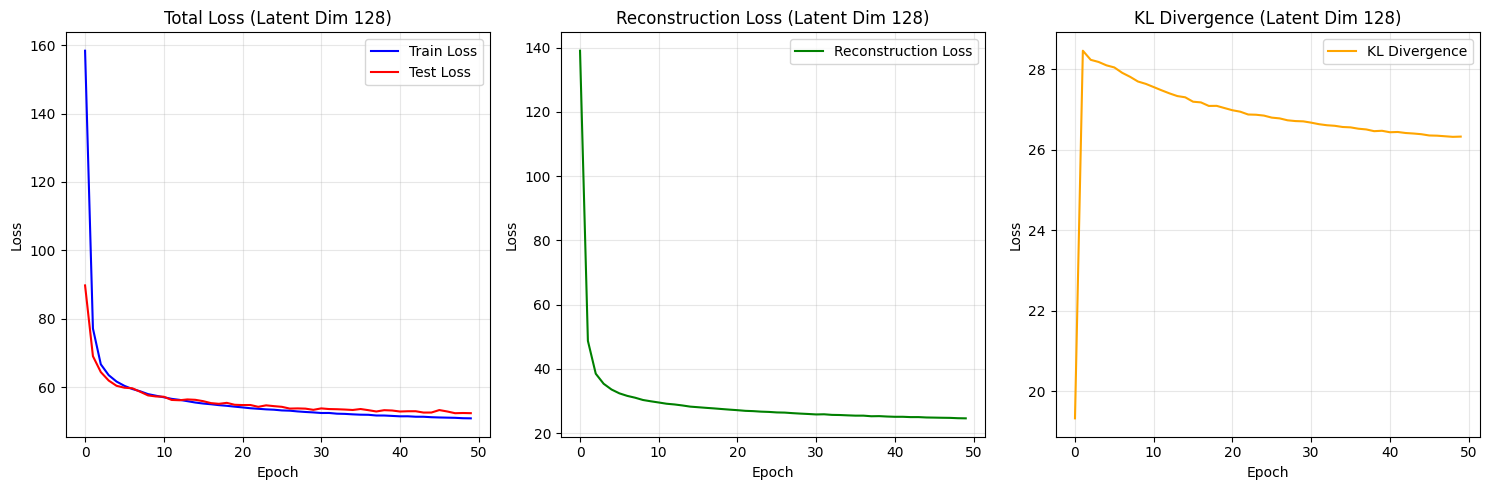

In [12]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses_128, label='Train Loss', color='blue')
plt.plot(test_losses_128, label='Test Loss', color='red')
plt.title('Total Loss (Latent Dim 128)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_recon_losses_128, label='Reconstruction Loss', color='green')
plt.title('Reconstruction Loss (Latent Dim 128)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(train_kl_losses_128, label='KL Divergence', color='orange')
plt.title('KL Divergence (Latent Dim 128)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Reconstruction Results (Latent Dim 128):


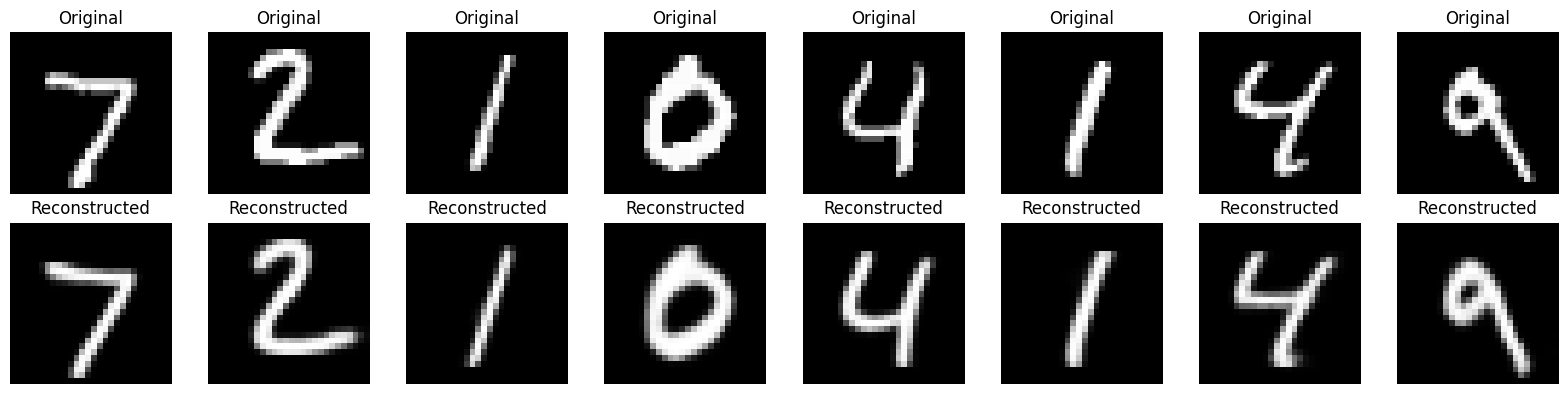

In [13]:
def visualize_reconstruction(model, test_loader, num_samples=8):
    """Visualize original images and their reconstructions"""
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        data, _ = next(iter(test_loader))
        data = data[:num_samples].to(device)
        
        # Reconstruct images
        recon_data, _, _ = model(data)
        
        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_samples, figsize=(16, 4))
        
        for i in range(num_samples):
            # Original images
            axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images
            axes[1, i].imshow(recon_data[i].cpu().squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize reconstructions for the 128-dim model
print("Reconstruction Results (Latent Dim 128):")
visualize_reconstruction(model_128, test_loader)

Generated Samples (Latent Dim 128):


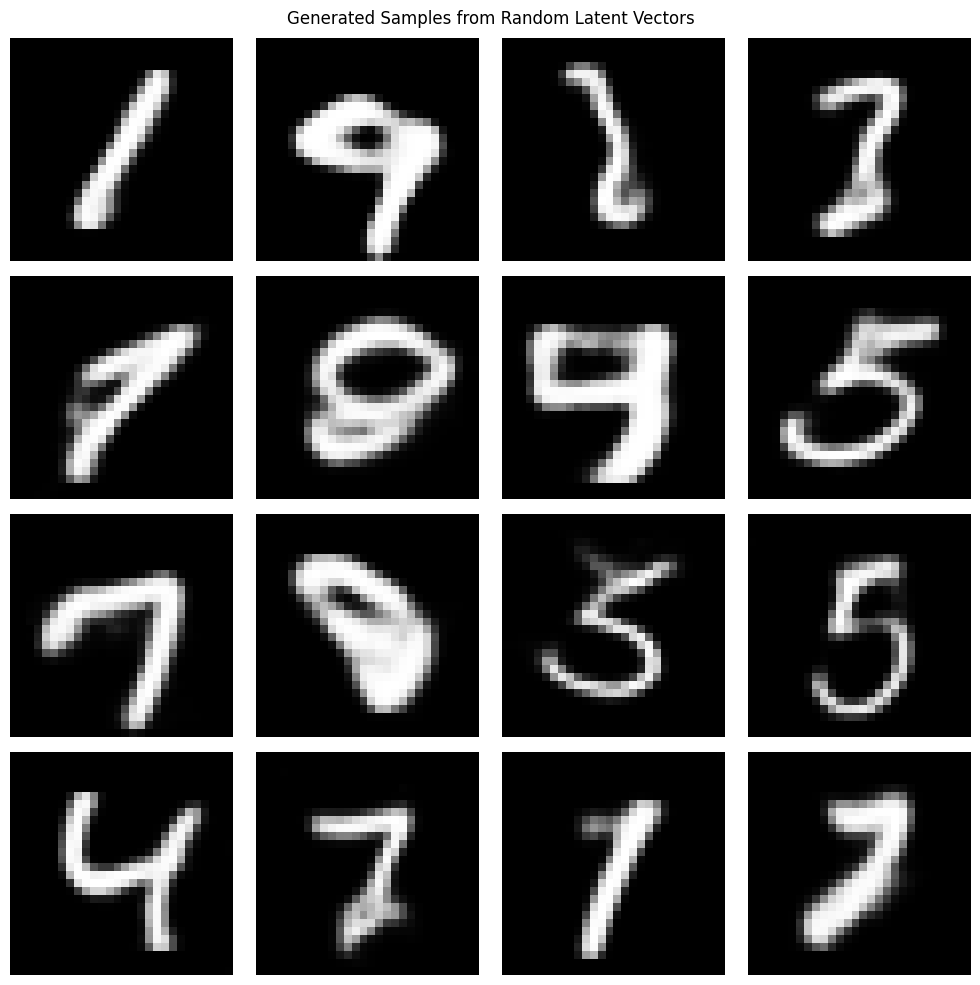

In [14]:
def generate_samples(model, num_samples=16):
    """Generate new samples by sampling from the latent space"""
    model.eval()
    with torch.no_grad():
        # Sample random vectors from standard normal distribution
        z = torch.randn(num_samples, model.latent_dim).to(device)
        
        # Generate images
        generated_images = model.decode(z)
        
        # Plot generated images
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        
        for i in range(num_samples):
            row = i // 4
            col = i % 4
            axes[row, col].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
            axes[row, col].axis('off')
        
        plt.suptitle('Generated Samples from Random Latent Vectors')
        plt.tight_layout()
        plt.show()

# Generate samples with the 128-dim model
print("Generated Samples (Latent Dim 128):")
generate_samples(model_128)

Latent Space Interpolation (Latent Dim 128):


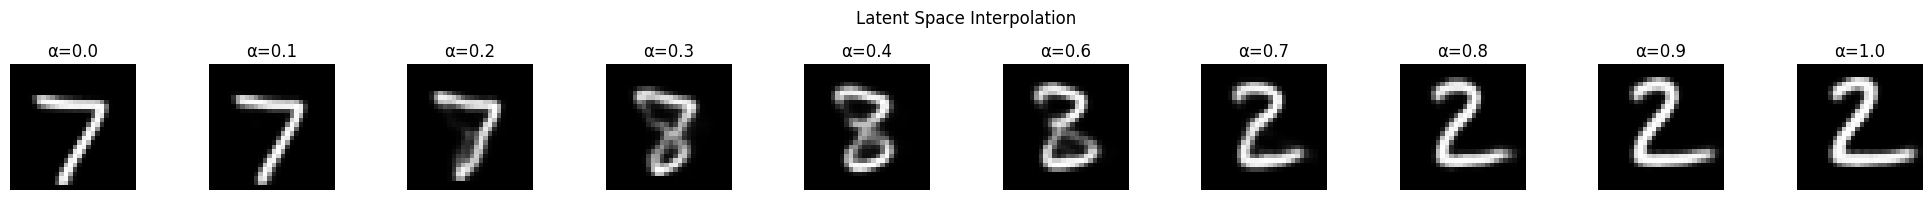

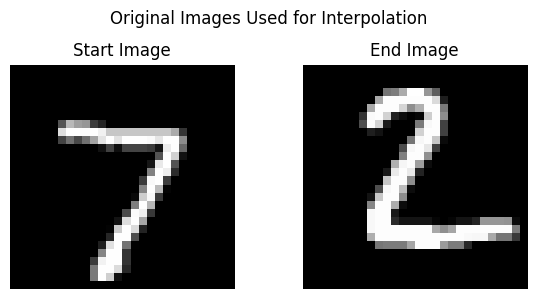

In [15]:
def interpolate_latent_space(model, test_loader, num_steps=10):
    """Interpolate between two latent vectors to show smooth transitions"""
    model.eval()
    with torch.no_grad():
        # Get two random test images
        data, _ = next(iter(test_loader))
        img1, img2 = data[0:1].to(device), data[1:2].to(device)
        
        # Encode to get latent representations
        mu1, _ = model.encode(img1)
        mu2, _ = model.encode(img2)
        
        # Create interpolation steps
        alphas = torch.linspace(0, 1, num_steps).to(device)
        
        # Generate interpolated images
        interpolated_images = []
        for alpha in alphas:
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            img_interp = model.decode(z_interp)
            interpolated_images.append(img_interp)
        
        # Plot interpolation
        fig, axes = plt.subplots(1, num_steps, figsize=(20, 2))
        
        for i, img in enumerate(interpolated_images):
            axes[i].imshow(img.cpu().squeeze(), cmap='gray')
            axes[i].set_title(f'α={alphas[i]:.1f}')
            axes[i].axis('off')
        
        plt.suptitle('Latent Space Interpolation')
        plt.tight_layout()
        plt.show()
        
        # Also show the original images used for interpolation
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        axes[0].imshow(img1.cpu().squeeze(), cmap='gray')
        axes[0].set_title('Start Image')
        axes[0].axis('off')
        
        axes[1].imshow(img2.cpu().squeeze(), cmap='gray')
        axes[1].set_title('End Image')
        axes[1].axis('off')
        
        plt.suptitle('Original Images Used for Interpolation')
        plt.tight_layout()
        plt.show()

# Demonstrate latent space interpolation
print("Latent Space Interpolation (Latent Dim 128):")
interpolate_latent_space(model_128, test_loader)

Latent Space Visualization (Latent Dim 128):


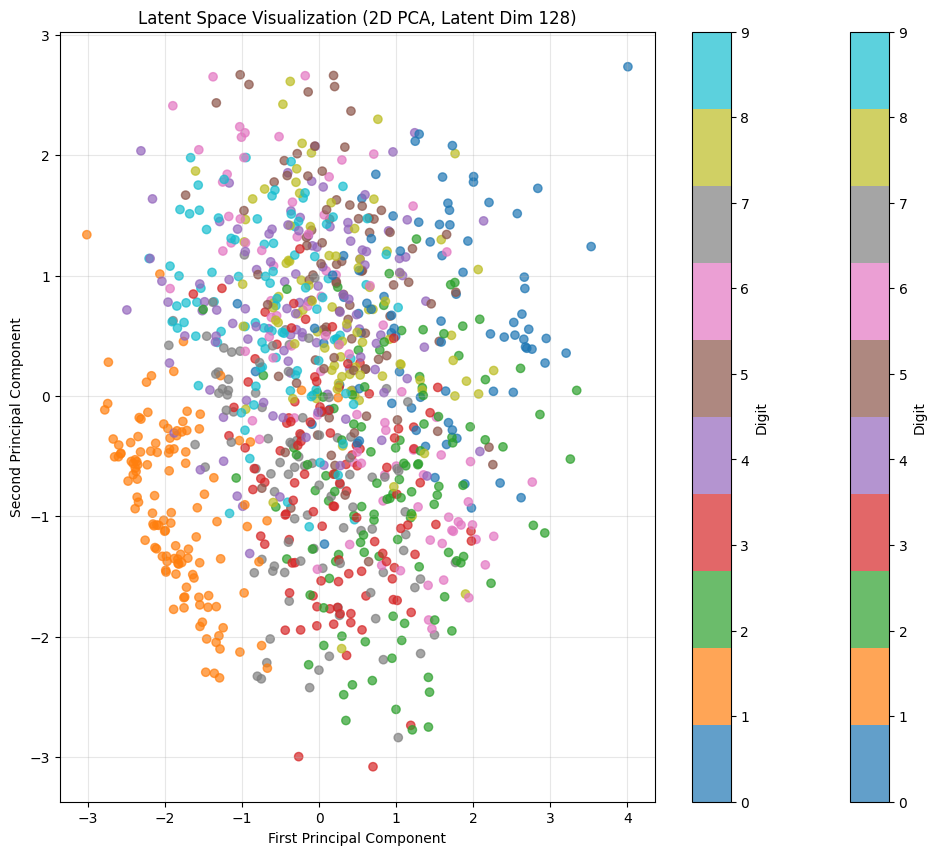

PCA explained variance ratio: [0.09153393 0.07822699]
Total explained variance: 0.1698


In [16]:
def visualize_latent_space_2d(model, test_loader, num_samples=1000):
    """
    Visualize the latent space in 2D using PCA dimensionality reduction
    This helps understand how the model organizes different digits in latent space
    """
    from sklearn.decomposition import PCA
    
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if len(latent_vectors) >= num_samples:
                break
                
            data = data.to(device)
            mu, _ = model.encode(data)
            
            latent_vectors.append(mu.cpu().numpy())
            labels.append(target.numpy())
    
    # Concatenate all latent vectors and labels
    latent_vectors = np.concatenate(latent_vectors, axis=0)[:num_samples]
    labels = np.concatenate(labels, axis=0)[:num_samples]
    
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)
    
    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit')
    plt.title(f'Latent Space Visualization (2D PCA, Latent Dim {model.latent_dim})')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True, alpha=0.3)
    
    # Add digit labels to colorbar
    cbar = plt.colorbar(scatter, label='Digit')
    cbar.set_ticks(range(10))
    
    plt.show()
    
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Visualize latent space for 128-dim model
print("Latent Space Visualization (Latent Dim 128):")
visualize_latent_space_2d(model_128, test_loader)

## Comparison with Latent Dimension 256

Now we will train another VAE with latent dimension 256 to compare the effect of different latent dimensionalities on reconstruction quality and generation capability.

In [17]:
# Training the VAE with latent dimension 256
latent_dim_256 = 256
model_256 = VAE(latent_dim=latent_dim_256).to(device)
optimizer_256 = optim.Adam(model_256.parameters(), lr=1e-3)

# Storage for training history
train_losses_256 = []
train_recon_losses_256 = []
train_kl_losses_256 = []
test_losses_256 = []

print("Training VAE with latent dimension 256...")
print("=" * 50)

for epoch in range(1, num_epochs + 1):
    # Train
    train_loss, train_recon_loss, train_kl_loss = train_vae(
        model_256, train_loader, optimizer_256, epoch, beta
    )
    
    # Test
    test_loss, test_recon_loss, test_kl_loss = test_vae(model_256, test_loader, beta)
    
    # Store losses
    train_losses_256.append(train_loss)
    train_recon_losses_256.append(train_recon_loss)
    train_kl_losses_256.append(train_kl_loss)
    test_losses_256.append(test_loss)
    
    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:02d}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'          Train Recon: {train_recon_loss:.4f}, Train KL: {train_kl_loss:.4f}')

print("Training completed!")
print("=" * 50)

# Save the trained model
torch.save(model_256.state_dict(), 'models/task_3/vae_256_final.pth')
print("Model saved to models/task_3/vae_256_final.pth")

Training VAE with latent dimension 256...


Epoch 1: 100%|██████████| 469/469 [00:07<00:00, 58.79it/s, Loss=108.5362, Recon=77.7615, KL=30.7748] 

Epoch 3: 100%|██████████| 469/469 [00:07<00:00, 58.72it/s, Loss=67.6561, Recon=39.4734, KL=28.1827]

Epoch 4: 100%|██████████| 469/469 [00:08<00:00, 57.48it/s, Loss=63.8684, Recon=34.4477, KL=29.4206]

Epoch 5: 100%|██████████| 469/469 [00:08<00:00, 58.28it/s, Loss=63.6114, Recon=37.1238, KL=26.4875]

Epoch 6: 100%|██████████| 469/469 [00:08<00:00, 58.62it/s, Loss=61.9623, Recon=33.7537, KL=28.2086]

Epoch 7: 100%|██████████| 469/469 [00:07<00:00, 59.17it/s, Loss=60.7358, Recon=32.0921, KL=28.6437]

Epoch 8: 100%|██████████| 469/469 [00:07<00:00, 59.03it/s, Loss=60.3416, Recon=32.4420, KL=27.8996]

Epoch 9: 100%|██████████| 469/469 [00:08<00:00, 57.50it/s, Loss=58.4704, Recon=29.5677, KL=28.9026]

Epoch 10: 100%|██████████| 469/469 [00:08<00:00, 57.89it/s, Loss=57.7546, Recon=29.5564, KL=28.1982]



Epoch 10: Train Loss: 58.9268, Test Loss: 58.5184
          Train Recon: 30.6804, Train KL: 28.2465


Epoch 11: 100%|██████████| 469/469 [00:08<00:00, 57.62it/s, Loss=58.0516, Recon=29.3734, KL=28.6782]

Epoch 13: 100%|██████████| 469/469 [00:08<00:00, 57.89it/s, Loss=54.9507, Recon=27.4495, KL=27.5012]

Epoch 14: 100%|██████████| 469/469 [00:08<00:00, 57.67it/s, Loss=55.3073, Recon=28.1937, KL=27.1137]

Epoch 15: 100%|██████████| 469/469 [00:08<00:00, 57.55it/s, Loss=55.2515, Recon=27.9468, KL=27.3046]

Epoch 16: 100%|██████████| 469/469 [00:08<00:00, 57.19it/s, Loss=57.2205, Recon=29.2002, KL=28.0204]

Epoch 17: 100%|██████████| 469/469 [00:08<00:00, 57.68it/s, Loss=54.4687, Recon=27.1240, KL=27.3447]

Epoch 18: 100%|██████████| 469/469 [00:08<00:00, 57.45it/s, Loss=55.4947, Recon=27.9634, KL=27.5314]

Epoch 19: 100%|██████████| 469/469 [00:08<00:00, 57.50it/s, Loss=54.4527, Recon=26.7520, KL=27.7007]

Epoch 20: 100%|██████████| 469/469 [00:08<00:00, 57.51it/s, Loss=56.1864, Recon=28.6252, KL=27.5612]


Epoch 20: Train Loss: 55.8121, Test Loss: 56.1107
          Train Recon: 28.0224, Train KL: 27.7897


Epoch 21: 100%|██████████| 469/469 [00:07<00:00, 58.82it/s, Loss=53.8223, Recon=26.7169, KL=27.1055]

Epoch 22: 100%|██████████| 469/469 [00:08<00:00, 58.23it/s, Loss=54.3804, Recon=26.0742, KL=28.3063]

Epoch 23: 100%|██████████| 469/469 [00:08<00:00, 58.50it/s, Loss=54.6608, Recon=27.3379, KL=27.3229]

Epoch 24: 100%|██████████| 469/469 [00:08<00:00, 58.52it/s, Loss=54.4826, Recon=27.0362, KL=27.4464]

Epoch 25: 100%|██████████| 469/469 [00:07<00:00, 58.78it/s, Loss=53.6455, Recon=26.7814, KL=26.8641]

Epoch 27: 100%|██████████| 469/469 [00:08<00:00, 58.28it/s, Loss=54.3649, Recon=26.6178, KL=27.7471]

Epoch 28: 100%|██████████| 469/469 [00:07<00:00, 58.82it/s, Loss=54.8268, Recon=27.2419, KL=27.5849]

Epoch 29: 100%|██████████| 469/469 [00:07<00:00, 58.77it/s, Loss=52.6476, Recon=26.1759, KL=26.4717]

Epoch 30: 100%|██████████| 469/469 [00:07<00:00, 59.13it/s, Loss=53.0941, Recon=26.2595, KL=26.8345]



Epoch 30: Train Loss: 54.1580, Test Loss: 54.9959
          Train Recon: 26.6562, Train KL: 27.5018


Epoch 31: 100%|██████████| 469/469 [00:07<00:00, 59.32it/s, Loss=49.1297, Recon=22.4779, KL=26.6518]

Epoch 33: 100%|██████████| 469/469 [00:08<00:00, 58.58it/s, Loss=53.8979, Recon=27.0260, KL=26.8720]

Epoch 34: 100%|██████████| 469/469 [00:07<00:00, 58.64it/s, Loss=54.8871, Recon=26.6614, KL=28.2257]

Epoch 35: 100%|██████████| 469/469 [00:07<00:00, 59.07it/s, Loss=56.3272, Recon=28.3540, KL=27.9732]

Epoch 36: 100%|██████████| 469/469 [00:07<00:00, 58.81it/s, Loss=52.8237, Recon=25.5844, KL=27.2392]

Epoch 37: 100%|██████████| 469/469 [00:07<00:00, 59.25it/s, Loss=49.0689, Recon=22.8285, KL=26.2404]

Epoch 38: 100%|██████████| 469/469 [00:07<00:00, 58.67it/s, Loss=53.2981, Recon=26.6448, KL=26.6533]

Epoch 39: 100%|██████████| 469/469 [00:08<00:00, 58.48it/s, Loss=55.0531, Recon=27.5077, KL=27.5454]

Epoch 40: 100%|██████████| 469/469 [00:07<00:00, 58.73it/s, Loss=52.9529, Recon=25.4820, KL=27.4709]


Epoch 40: Train Loss: 53.0676, Test Loss: 54.3680
          Train Recon: 25.8477, Train KL: 27.2198


Epoch 41: 100%|██████████| 469/469 [00:07<00:00, 59.14it/s, Loss=53.1014, Recon=26.6976, KL=26.4038]

Epoch 42: 100%|██████████| 469/469 [00:08<00:00, 56.69it/s, Loss=53.9920, Recon=26.2524, KL=27.7397]

Epoch 43: 100%|██████████| 469/469 [00:07<00:00, 59.08it/s, Loss=51.6534, Recon=24.6386, KL=27.0148]

Epoch 44: 100%|██████████| 469/469 [00:07<00:00, 59.48it/s, Loss=51.2556, Recon=24.0709, KL=27.1846]

Epoch 46: 100%|██████████| 469/469 [00:07<00:00, 60.37it/s, Loss=51.4110, Recon=24.8671, KL=26.5438]

Epoch 47: 100%|██████████| 469/469 [00:07<00:00, 62.45it/s, Loss=53.7818, Recon=26.1103, KL=27.6715]

Epoch 48: 100%|██████████| 469/469 [00:07<00:00, 62.85it/s, Loss=50.3118, Recon=24.3608, KL=25.9510]

Epoch 49: 100%|██████████| 469/469 [00:07<00:00, 62.95it/s, Loss=54.8734, Recon=27.5360, KL=27.3374]

Epoch 50: 100%|██████████| 469/469 [00:07<00:00, 62.78it/s, Loss=52.3296, Recon=25.2426, KL=27.0870]



Epoch 50: Train Loss: 52.2295, Test Loss: 53.4342
          Train Recon: 25.2377, Train KL: 26.9918
Training completed!
Model saved to models/task_3/vae_256_final.pth


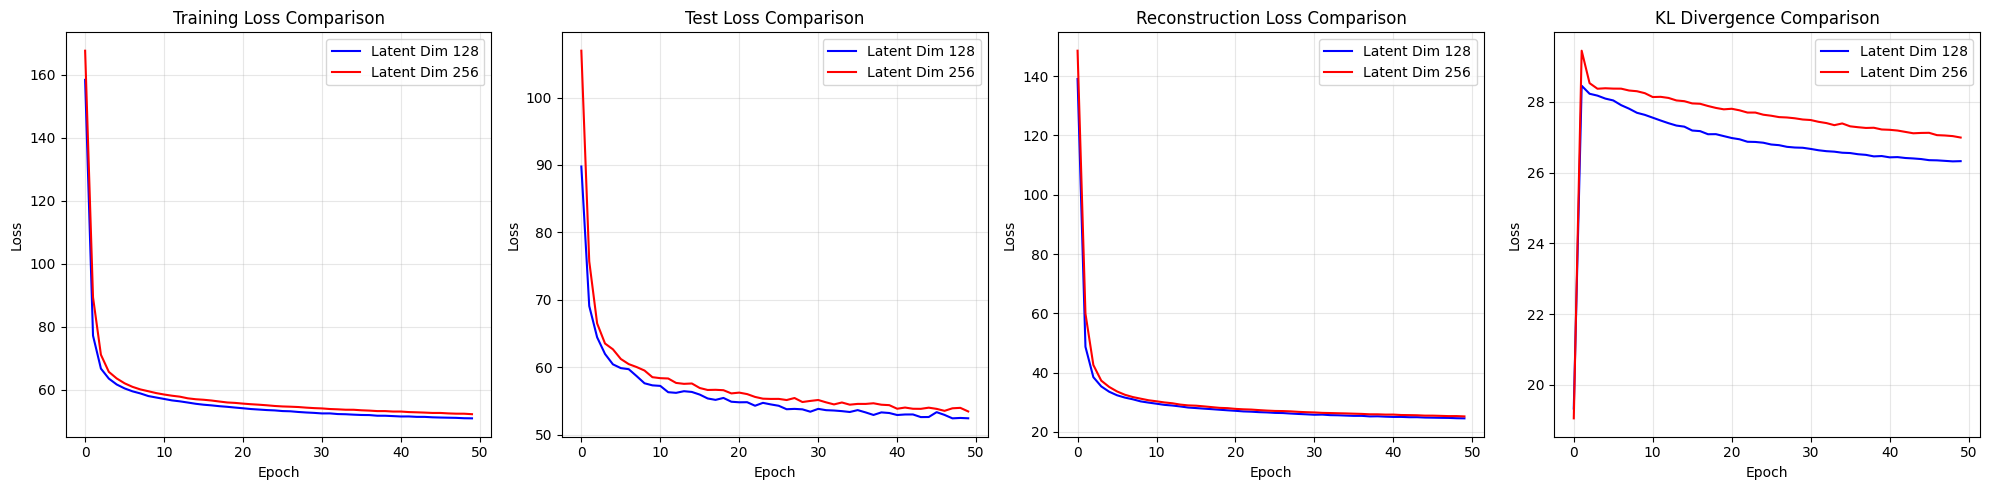

Final Performance Comparison:
Latent Dim 128 - Final Test Loss: 52.4180
Latent Dim 256 - Final Test Loss: 53.4342
Latent Dim 128 - Final Reconstruction Loss: 24.5858
Latent Dim 256 - Final Reconstruction Loss: 25.2377
Latent Dim 128 - Final KL Loss: 26.3241
Latent Dim 256 - Final KL Loss: 26.9918


In [18]:
# Compare training curves between 128 and 256 dimensional models
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(train_losses_128, label='Latent Dim 128', color='blue')
plt.plot(train_losses_256, label='Latent Dim 256', color='red')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 2)
plt.plot(test_losses_128, label='Latent Dim 128', color='blue')
plt.plot(test_losses_256, label='Latent Dim 256', color='red')
plt.title('Test Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 3)
plt.plot(train_recon_losses_128, label='Latent Dim 128', color='blue')
plt.plot(train_recon_losses_256, label='Latent Dim 256', color='red')
plt.title('Reconstruction Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 4, 4)
plt.plot(train_kl_losses_128, label='Latent Dim 128', color='blue')
plt.plot(train_kl_losses_256, label='Latent Dim 256', color='red')
plt.title('KL Divergence Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final performance comparison
print("Final Performance Comparison:")
print("=" * 40)
print(f"Latent Dim 128 - Final Test Loss: {test_losses_128[-1]:.4f}")
print(f"Latent Dim 256 - Final Test Loss: {test_losses_256[-1]:.4f}")
print(f"Latent Dim 128 - Final Reconstruction Loss: {train_recon_losses_128[-1]:.4f}")
print(f"Latent Dim 256 - Final Reconstruction Loss: {train_recon_losses_256[-1]:.4f}")
print(f"Latent Dim 128 - Final KL Loss: {train_kl_losses_128[-1]:.4f}")
print(f"Latent Dim 256 - Final KL Loss: {train_kl_losses_256[-1]:.4f}")

Reconstruction Quality Comparison:


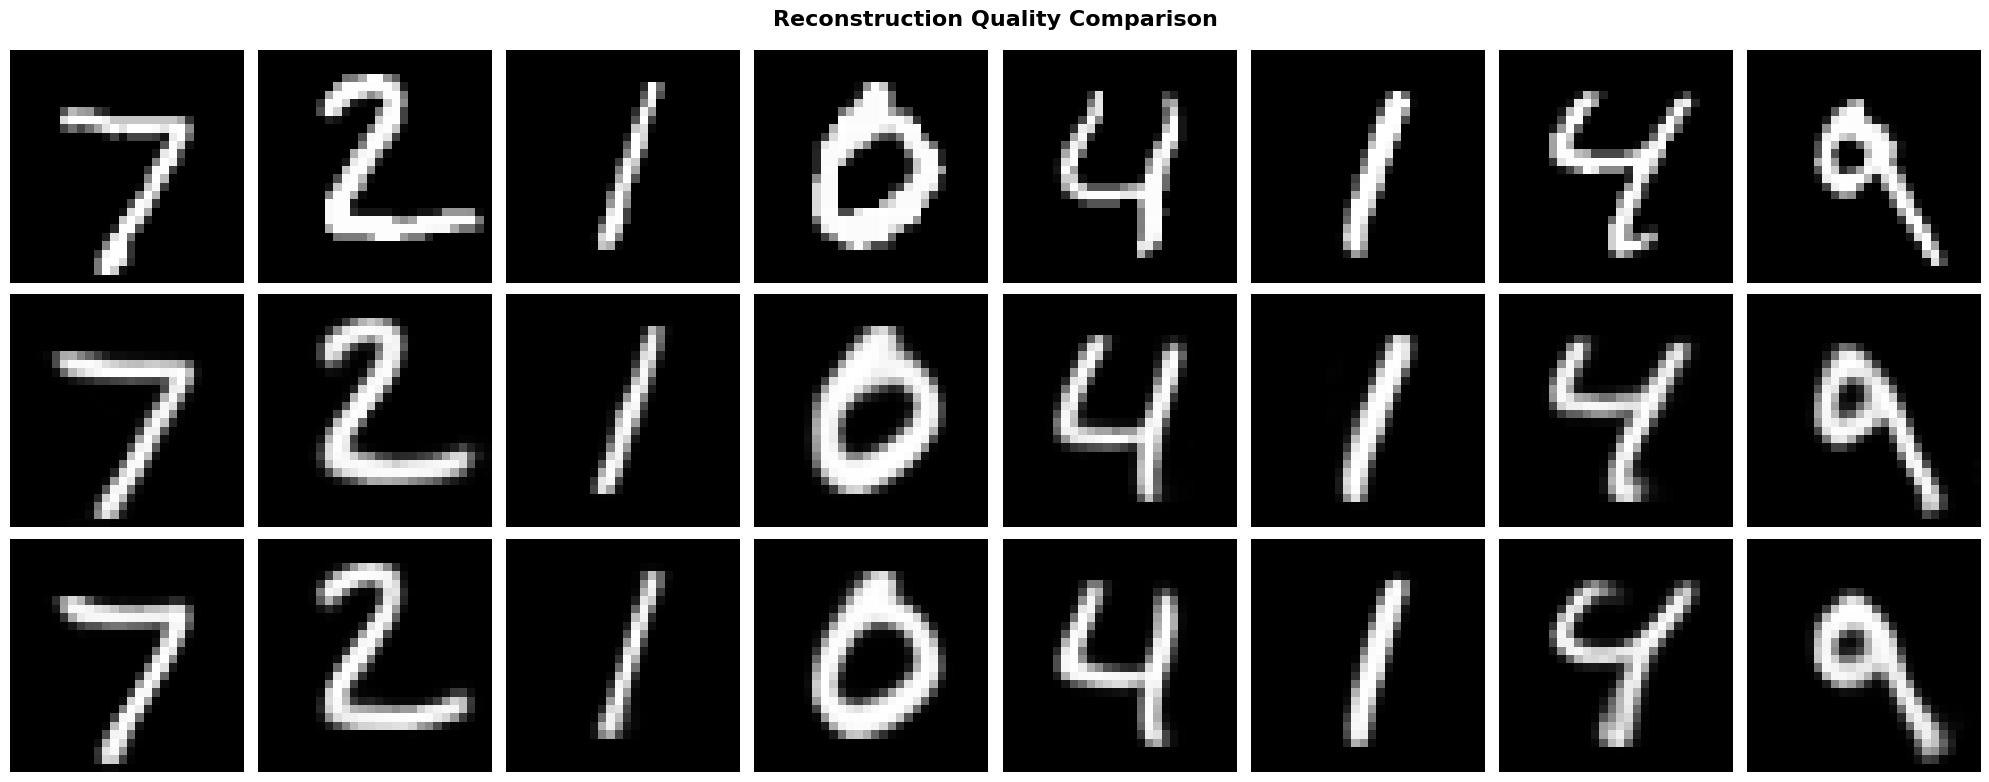

In [19]:
# Side-by-side reconstruction comparison
def compare_reconstructions(model1, model2, test_loader, model1_name, model2_name, num_samples=8):
    """Compare reconstructions between two models"""
    model1.eval()
    model2.eval()
    
    with torch.no_grad():
        # Get a batch of test images
        data, _ = next(iter(test_loader))
        data = data[:num_samples].to(device)
        
        # Reconstruct with both models
        recon1, _, _ = model1(data)
        recon2, _, _ = model2(data)
        
        # Plot comparison
        fig, axes = plt.subplots(3, num_samples, figsize=(20, 8))
        
        for i in range(num_samples):
            # Original images
            axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
            if i == 0:
                axes[0, i].set_ylabel('Original', fontsize=12, fontweight='bold')
            axes[0, i].axis('off')
            
            # Model 1 reconstructions
            axes[1, i].imshow(recon1[i].cpu().squeeze(), cmap='gray')
            if i == 0:
                axes[1, i].set_ylabel(f'{model1_name}', fontsize=12, fontweight='bold')
            axes[1, i].axis('off')
            
            # Model 2 reconstructions
            axes[2, i].imshow(recon2[i].cpu().squeeze(), cmap='gray')
            if i == 0:
                axes[2, i].set_ylabel(f'{model2_name}', fontsize=12, fontweight='bold')
            axes[2, i].axis('off')
        
        plt.suptitle('Reconstruction Quality Comparison', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Compare reconstructions
print("Reconstruction Quality Comparison:")
compare_reconstructions(model_128, model_256, test_loader, 'Latent Dim 128', 'Latent Dim 256')

Generated Sample Quality Comparison:


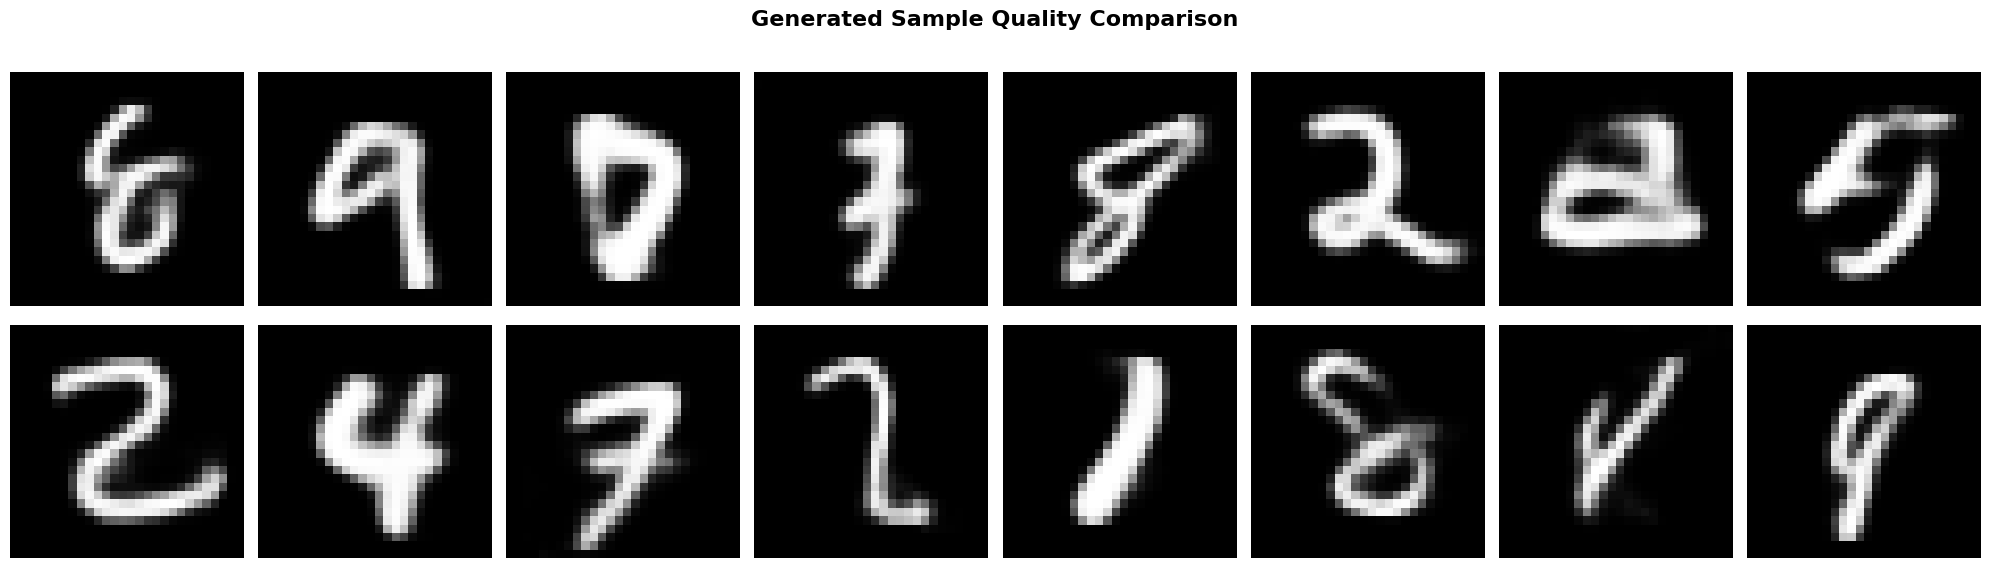

In [20]:
# Compare generated samples
def compare_generations(model1, model2, model1_name, model2_name, num_samples=16):
    """Compare generated samples between two models"""
    model1.eval()
    model2.eval()
    
    with torch.no_grad():
        # Use the same random seed for fair comparison
        torch.manual_seed(42)
        z1 = torch.randn(num_samples, model1.latent_dim).to(device)
        
        torch.manual_seed(42)
        z2 = torch.randn(num_samples, model2.latent_dim).to(device)
        
        # Generate images
        gen1 = model1.decode(z1)
        gen2 = model2.decode(z2)
        
        # Plot comparison
        fig, axes = plt.subplots(2, 8, figsize=(20, 6))
        
        for i in range(8):
            # Model 1 generations
            axes[0, i].imshow(gen1[i].cpu().squeeze(), cmap='gray')
            if i == 0:
                axes[0, i].set_ylabel(f'{model1_name}', fontsize=12, fontweight='bold')
            axes[0, i].axis('off')
            
            # Model 2 generations
            axes[1, i].imshow(gen2[i].cpu().squeeze(), cmap='gray')
            if i == 0:
                axes[1, i].set_ylabel(f'{model2_name}', fontsize=12, fontweight='bold')
            axes[1, i].axis('off')
        
        plt.suptitle('Generated Sample Quality Comparison', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Compare generated samples
print("Generated Sample Quality Comparison:")
compare_generations(model_128, model_256, 'Latent Dim 128', 'Latent Dim 256')

Latent Space Comparison:
Latent Dimension 128:


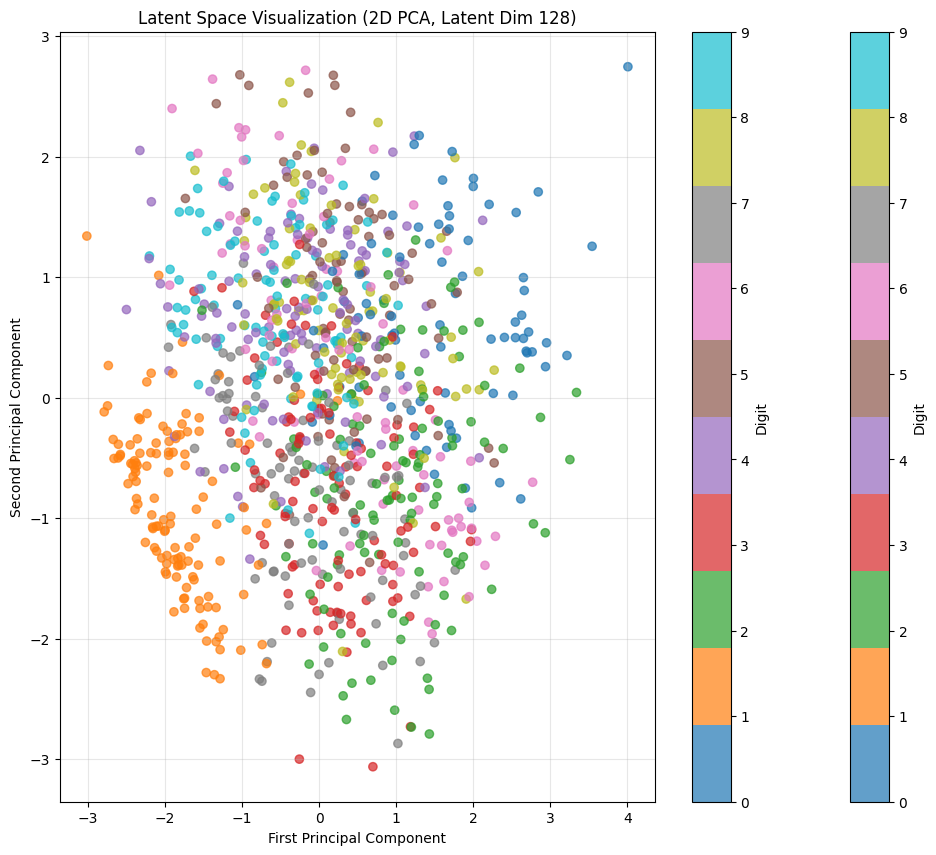

PCA explained variance ratio: [0.09153355 0.07823829]
Total explained variance: 0.1698

Latent Dimension 256:


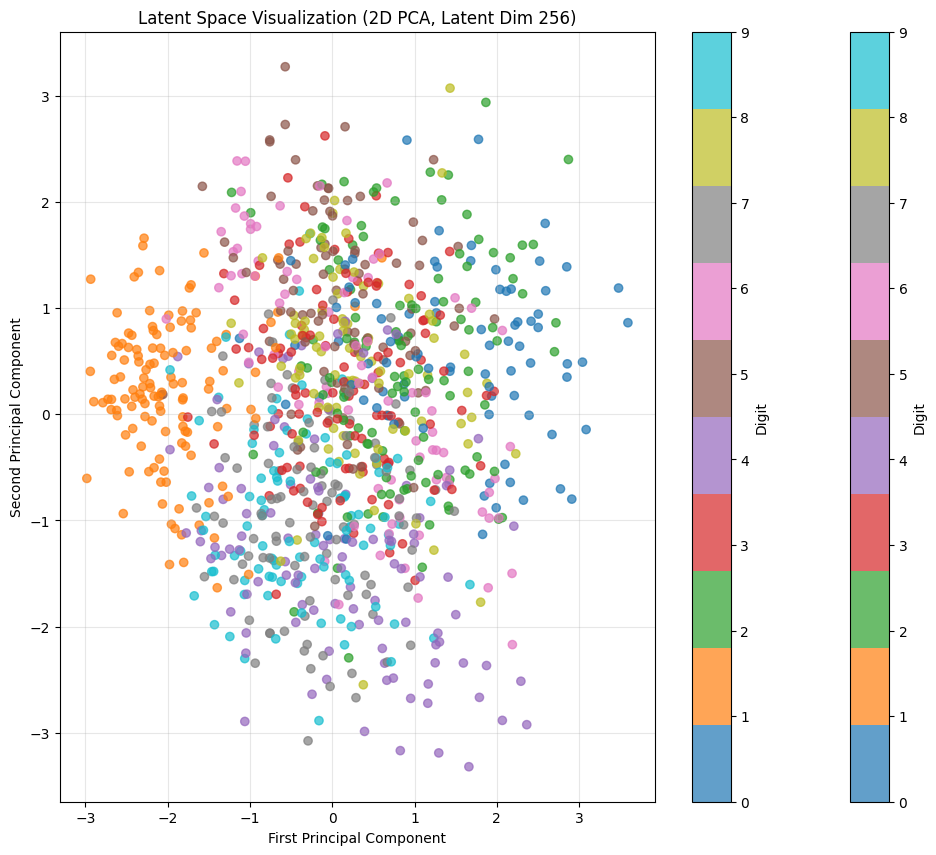

PCA explained variance ratio: [0.0835251  0.07759236]
Total explained variance: 0.1611


In [21]:
# Compare latent space visualizations
print("Latent Space Comparison:")
print("Latent Dimension 128:")
visualize_latent_space_2d(model_128, test_loader, num_samples=1000)

print("\nLatent Dimension 256:")
visualize_latent_space_2d(model_256, test_loader, num_samples=1000)

Interpolation Quality Comparison:
Latent Dimension 128:


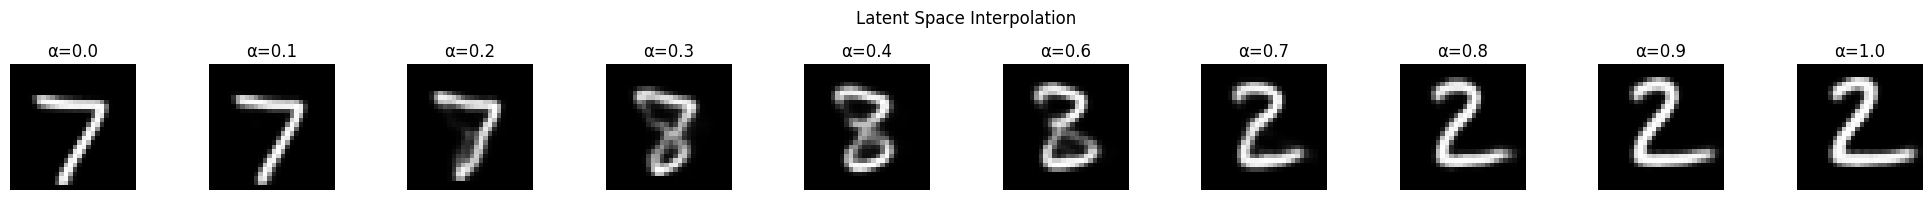

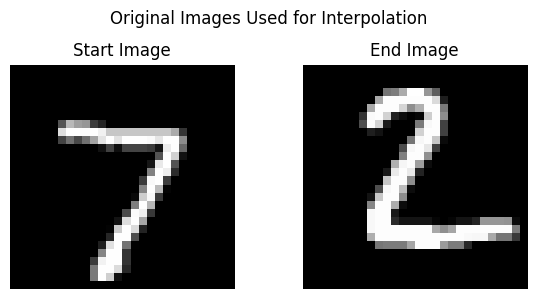


Latent Dimension 256:


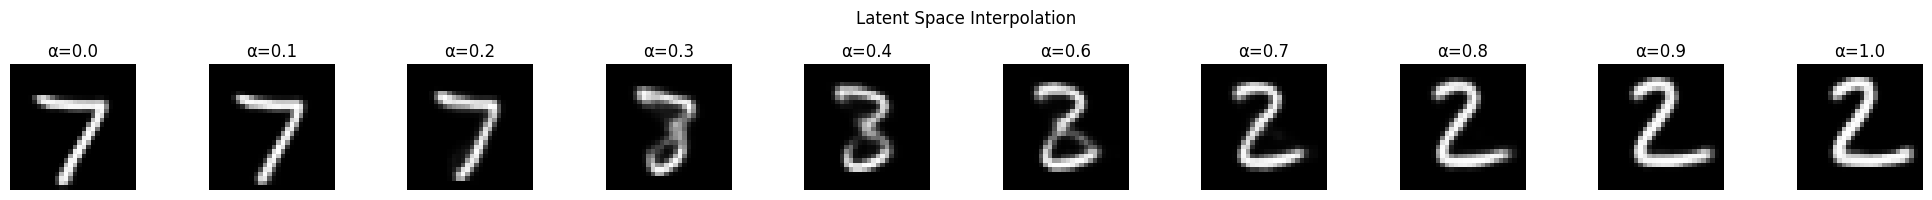

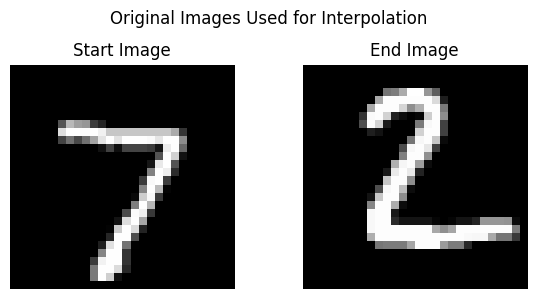

In [22]:
# Compare interpolation quality
print("Interpolation Quality Comparison:")
print("Latent Dimension 128:")
interpolate_latent_space(model_128, test_loader, num_steps=10)

print("\nLatent Dimension 256:")
interpolate_latent_space(model_256, test_loader, num_steps=10)

## Summary and Analysis

This task involved building and training a Variational Autoencoder (VAE), a type of neural network that learns to compress and then reconstruct images. The goal was to train it on the MNIST dataset of handwritten digits to create a "latent space," which is a low-dimensional, compressed representation of the images.

The project compared two different VAE models:
1.  **VAE-128:** A model with a latent dimension of 128.
2.  **VAE-256:** A model with a latent dimension of 256.

Both models were trained for 50 epochs to see how the size of this latent space affects the model's ability to recreate images, generate new ones, and organize its learned information.

---

### Analysis of Results

The two models were compared based on their final performance metrics and visual quality.

#### 1. Quantitative Comparison (Loss Metrics)

The training results show how well each model performed at its two main jobs: reconstructing the image (Reconstruction Loss) and keeping the latent space organized (KL Divergence).

| Metric | VAE (Latent Dim 128) | VAE (Latent Dim 256) |
| :--- | :--- | :--- |
| **Final Test Loss (Total)** | **52.4180** | 53.4342 |
| **Final Recon. Loss** | **24.5858** | 25.2377 |
| **Final KL Loss** | 26.3241 | **26.9918** |

*(Data from source)*

**Analysis:**
* **Reconstruction:** The VAE-128 model achieved a slightly **lower** reconstruction loss. This means it was slightly better at recreating the original digits after compressing them.
* **Total Loss:** Because its reconstruction loss was better, the VAE-128 model also had a lower overall final test loss.
* **KL Divergence:** The VAE-256 model had a higher KL loss. This is expected. A larger latent space (256) is harder to "regularize" (keep organized), so the "cost" for this organization is higher.

#### 2. Qualitative (Visual) Comparison

* **Reconstruction Quality (Page 28):** Both models produced excellent, sharp reconstructions of the test digits. Visually, it is very difficult to see any difference between the VAE-128 and VAE-256 results. Both successfully captured the shapes of digits like '7', '2', '1', and '0'.
* **Generated Samples (Page 29):** When generating new digits from random latent vectors, both models produced clear, plausible-looking digits. Neither model was clearly better than the other in terms of image quality or diversity.
* **Latent Space Interpolation (Page 32):** Both models showed a very smooth and logical transition when "walking" from one digit to another in the latent space (e.g., transforming a '7' into a '2'). This shows that both models learned a well-organized space where similar-looking digits are grouped together.

### Conclusion

In this experiment, the VAE with a **latent dimension of 128 performed slightly better** than the model with 256 dimensions. It achieved a lower final test loss, driven by a better reconstruction loss.

This result suggests that a larger latent space is not always better. For the MNIST dataset, a 128-dimension space seems to be perfectly "just right"—it is large enough to capture all the important features of the digits but small enough to be regularized efficiently. The 256-dimension space may have been unnecessarily large, making it slightly harder for the model to learn the most efficient compression, which resulted in a small drop in reconstruction quality.